In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Đọc dữ liệu
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/btc_data.csv')

# Tiền xử lý
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df = df.dropna()

In [4]:
# Đặc trưng và nhãn
X = df.drop(columns=['Date', 'priceUSD'])
y = df['priceUSD']

In [5]:
# Chia dữ liệu 80-10-10
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.10, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1111, shuffle=False)

In [6]:
# Chuẩn hóa
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [7]:
# RandomizedSearchCV cho SVR
param_distributions = {
    'C': np.logspace(-2, 3, 100),
    'epsilon': np.linspace(0.001, 1, 100),
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4, 5],  # chỉ dùng cho poly
    'gamma': ['scale', 'auto'] + list(np.logspace(-4, 1, 6))  # dùng cho rbf, poly, sigmoid
}
svr = SVR()
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)
random_search = RandomizedSearchCV(svr, param_distributions, n_iter=50, cv=tscv, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=SVR(), n_iter=50,
                   param_distributions={'C': array([1.00000000e-02, 1.12332403e-02, 1.26185688e-02, 1.41747416e-02,
       1.59228279e-02, 1.78864953e-02, 2.00923300e-02, 2.25701972e-02,
       2.53536449e-02, 2.84803587e-02, 3.19926714e-02, 3.59381366e-02,
       4.03701726e-02, 4.5348...
       0.85872727, 0.86881818, 0.87890909, 0.889     , 0.89909091,
       0.90918182, 0.91927273, 0.92936364, 0.93945455, 0.94954545,
       0.95963636, 0.96972727, 0.97981818, 0.98990909, 1.        ]),
                                        'gamma': ['scale', 'auto',
                                                  np.float64(0.0001),
                                                  np.float64(0.001),
                                                  np.float64(0.01),
                                                  np.float64(0.1),
                                                  np.float64(1.0),
                                                  np.float64(10.0)],
                                        'kernel': ['linear', 'rbf', 'poly',
                                                   'sigmoid']},
                   random_state=42, scoring='neg_mean_squared_error')

In [8]:
# Mô hình tốt nhất
best_model = random_search.best_estimator_

# Dự đoán trên tập test
y_pred = best_model.predict(X_test_scaled)

In [9]:
# Đánh giá trên từng tập
def evaluate(model, X, y):
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    return mae, mape, rmse, r2

mae_train, mape_train, rmse_train, r2_train = evaluate(best_model, X_train_scaled, y_train)
mae_val, mape_val, rmse_val, r2_val = evaluate(best_model, X_val_scaled, y_val)
mae_test, mape_test, rmse_test, r2_test = evaluate(best_model, X_test_scaled, y_test)

# In kết quả
best_params = random_search.best_params_
print(f"✅ Best Parameters: C={best_params['C']}, epsilon={best_params['epsilon']}")
print(f"📊 Train     - MAE: {mae_train:.2f}, MAPE: {mape_train:.4f}, RMSE: {rmse_train:.2f}, R²: {r2_train:.4f}")
print(f"📊 Validate  - MAE: {mae_val:.2f}, MAPE: {mape_val:.4f}, RMSE: {rmse_val:.2f}, R²: {r2_val:.4f}")
print(f"📊 Test      - MAE: {mae_test:.2f}, MAPE: {mape_test:.4f}, RMSE: {rmse_test:.2f}, R²: {r2_test:.4f}")

✅ Best Parameters: C=890.2150854450392, epsilon=0.6165454545454546
📊 Train     - MAE: 98.08, MAPE: 0.0445, RMSE: 168.10, R²: 0.9996
📊 Validate  - MAE: 847.11, MAPE: 0.0185, RMSE: 1178.06, R²: 0.9847
📊 Test      - MAE: 1168.29, MAPE: 0.0461, RMSE: 1436.59, R²: 0.9779


In [10]:
# Bảng so sánh
results = pd.DataFrame({
    'Date': df.loc[y_test.index, 'Date'],  # lấy đúng ngày theo chỉ số y_test
    'Actual': y_test.values,
    'Predicted': y_pred
}).reset_index(drop=True)

print(results.head())

        Date   Actual     Predicted
0 2022-02-08  43854.0  44317.193866
1 2022-02-09  43922.0  44698.622624
2 2022-02-10  44331.0  45585.862487
3 2022-02-11  43185.0  44191.354562
4 2022-02-12  42333.0  42700.005810


<ipython-input-11-bb30c1c6b192>:29: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


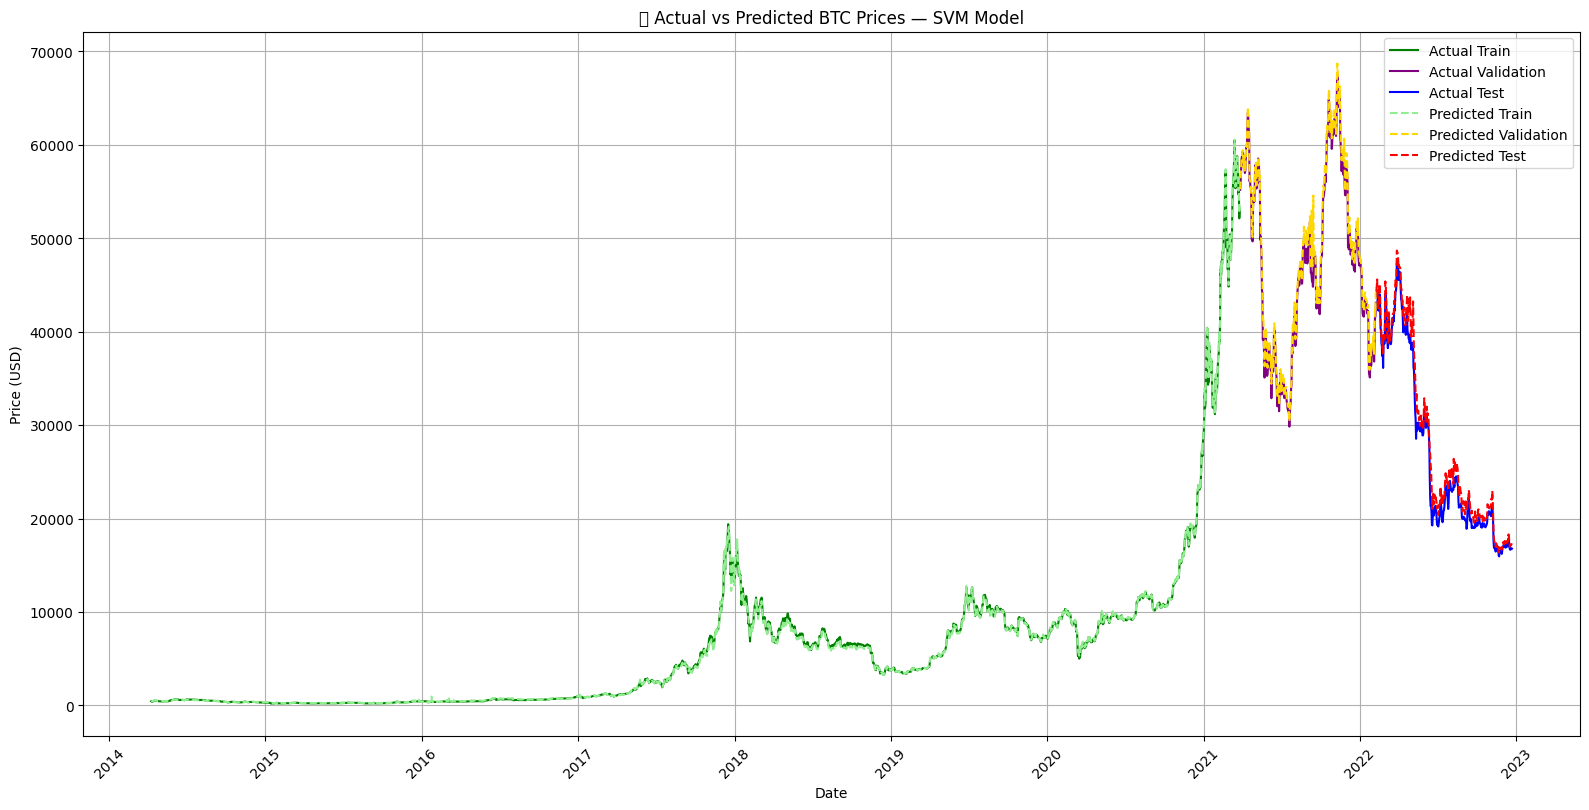

In [11]:
# === Dự đoán trên cả Train và Validation ===
y_train_pred = best_model.predict(X_train_scaled)
y_val_pred = best_model.predict(X_val_scaled)

# Lấy lại thời gian tương ứng
train_dates = df.iloc[y_train.index]['Date']
val_dates = df.iloc[y_val.index]['Date']
test_dates = df.iloc[y_test.index]['Date']

# === Biểu đồ: Actual vs Predicted cho Train, Validation, Test ===
plt.figure(figsize=(16, 8))

# Actual lines
plt.plot(train_dates, y_train.values, label='Actual Train', color='green')
plt.plot(val_dates, y_val.values, label='Actual Validation', color='purple')
plt.plot(test_dates, y_test.values, label='Actual Test', color='blue')

# Predicted lines
plt.plot(train_dates, y_train_pred, label='Predicted Train', color='lightgreen', linestyle='--')
plt.plot(val_dates, y_val_pred, label='Predicted Validation', color='gold', linestyle='--')
plt.plot(test_dates, y_pred, label='Predicted Test', color='red', linestyle='--')

# Format
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('📊 Actual vs Predicted BTC Prices — SVM Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


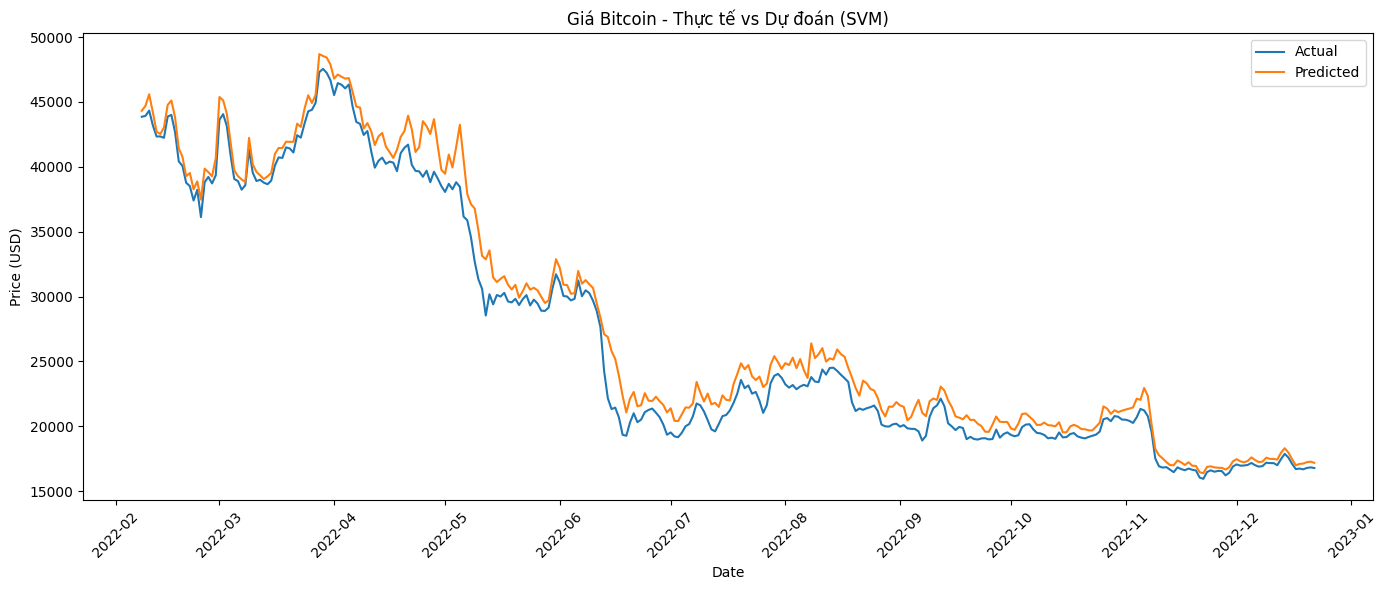

In [12]:
# Vẽ đồ thị
plt.figure(figsize=(14, 6))
sns.lineplot(data=results, x='Date', y='Actual', label='Actual')
sns.lineplot(data=results, x='Date', y='Predicted', label='Predicted')
plt.title("Giá Bitcoin - Thực tế vs Dự đoán (SVM)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()